# Full Model Training Pipeline
In this notebook we are modifying the LeNet nn to 3 color images instead of black an white. I implement a simple model training pipeline (pre-processing, train, and test)

In [27]:
%matplotlib inline

import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 

import torchvision
import torchvision.transforms as transforms 

import matplotlib 
import matplotlib.pyplot as plt 
import numpy as np 




First, taining and test datasets. 

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,0.5,0.5), (0.5, 0.5, 0.5))]
)

# training data 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                       download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                          shuffle=True, num_workers=2)

# test data 
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform) # download testset with given parameters
testloader = torch.utils.data.DataLoader(testset, batch_size=4, 
                                          shuffle=False, num_workers=2) # create a testloader that holds the formatted test data for us to use 

In [29]:
classes = ('plane', 'car', 'bird', 'cat', 
           'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

## Check Output from ```DataLoader```:

  dog   cat  frog   cat


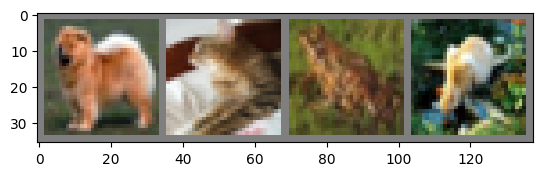

In [30]:
import matplotlib.pyplot as plt 
import numpy as np 

# functions to show an image 

def imshow(img):
    img = img / 2 + 0.5 # unormalize 
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

# get some random training images 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images 
imshow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Model to Train 
Variant of LeNet adapted for 3 color images

In [31]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # relu function to keep important features only 
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) # # Flatten 3D "bricks" into 1D "strips". Shape: [4 images, 400 features each] 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


```x = x.view(-1, 16 * 5 * 5)``` mental model:
| Image Index | Feature 1 | Feature 2 | ... | Feature 400 |
| :--- | :--- | :--- | :--- | :--- |
| **Image 0 (Cat)** | 0.45 | -1.2 | ... | 0.88 |
| **Image 1 (Car)** | -0.12 | 0.55 | ... | -0.32 |
| **Image 2 (Bird)** | 1.10 | 0.02 | ... | 0.41 |
| **Image 3 (Dog)** | -0.98 | -0.4 | ... | 0.15 |

ReLU activation function: 
$$f(x) = \max(0, x)$$

## Final Ingredients needed are a Loss Function and an Optimizer:

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Loss function is a measure of how far from our ideal output the model's prediction was. <strong>Cross-entropy loss</strong> is a typical loss function for classification models like this one. 

The <strong>optimizer</strong> is what drives the learning. Here the optimizer implements <i>stochastic gradient descent</i>, a straightforward optimization algorithm. Besides params of the algorithm like the learning rate (```lr```) and momentum, we also pass in ```net.parameters()``` being a collection of all learning weights of the model. - optimizer adjusts these. 

how they work together: 
The goal is to update a weight ($w$) by calculating the gradient ($\nabla$) of the loss ($L$):
$$w_{new} = w_{old} - \eta \cdot \nabla L$$

1. **Forward Pass**: The model guesses an image.
2. **Criterion**: Measures the error (Loss).
3. **Backward Pass**: Calculates which weights caused that error (Gradients).
4. **Optimizer**: Tweaks those weights slightly ($w_{new}$) to make the error smaller next time.

Finally, eveything is assembled into the training loop: 

In [ ]:
for epoch in range(2): # loop over dataset # of times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs 
        inputs, labels = data # images and their associated features

        # zero the parameter gradients 
        optimizer.zero_grad() # **important**

        # forward + backward + optimize 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print stats 
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % 
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.213
[1,  4000] loss: 1.928
[1,  6000] loss: 1.686
[1,  8000] loss: 1.616
[1, 10000] loss: 1.511
[1, 12000] loss: 1.477
[2,  2000] loss: 1.384
[2,  4000] loss: 1.371
[2,  6000] loss: 1.333
[2,  8000] loss: 1.320
[2, 10000] loss: 1.318
[2, 12000] loss: 1.305
Finished Training


## Understanding the Code 
We are running the model for 2 epochs. We also declare a running loss before entering the nested for loop. 

### Inner for loop 
```trainloader``` is our delivery truck of training data. 

```data``` is a single package taken from that truck.

```optimizer.zero_grad()``` This is an important line since PyTorch accumulates gradients. this will reset them so that the batches will not be mixed together during learning. 

```
# forward + backward + optimize 
outputs = net(inputs)
loss = criterion(outputs, labels)
loss.backward()
optimizer.step()
```
This is the models pipeline where it looks at 4 images and guesses it's classification, the loss compares the model's guesses to the real labels and calculates a "Error Score" (the Loss), ```backward()``` then works backword through the network to find the weights responsible for the error, and finally the optimizer uses those instructions to tweak the weights in the right direction. 

As a final step we need to ensure the model is doing *general* learning instead of simply "memorizing" the dataset. this is called **overfitting** and it indicates that the dataset is too small (not enough examples for general learning), or the model has more learning params than it needs to correctly model the dataset. 

For this reason the datasets are split into training and test subsets. To test the generality of the model we ask it to make predictions on data it hasnt been trained on: 

## Test Model

In [34]:
correct = 0
total = 0
with torch.no_grad(): # tell PyTorch not to compute gradiets for training 
    for data in testloader: 
        images, labels = data # unpack first package into image, label components
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1) # In this batch find the column with the highest score for each row. 
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' %(
    100 * correct / total
))


Accuracy of the network on the 10000 test images: 56 %


```_, predicted = torch.max(outputs.data, 1)``` This line helps us take the highest score classification for each image. It will go through each row in the batch (each image) and find the column (class) with the highest score for each. 

## Model Results
In this implementation our model performed with a 56% degree of accuracy. Not a state of the art performance, but better than guessing and can improve.